# CapStone project

# Project: Intrusions Detection

# Getting Started
In this project, i will  build a software to detect network intrusions protects a computer network from unauthorized users, including perhaps insiders.  
The intrusion detector learning task is to build a predictive model (i.e. a classifier) capable of distinguishing between ``bad'' connections, called intrusions or attacks, and ``good'' normal connections. Data will be used is ( [NSL-KDD](https://www.unb.ca/cic/datasets/nsl.html?fbclid=IwAR3fJFxBM_mqWcteKk9q0i5uY6eEGbdwZSxjBjlaSTv06ViXWTG4-RZ5M_I) ) dataset set it’s a data set suggested solving some of the inherent problems of the ([KDD Cup'99](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html)) data set.

# Connect to google drive

In [1]:
#Connect to google drive to load data from it
#if you run Notebook localy you don't need to excute this cell and the next cell
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130811 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
#make directory to drive in colab drive
!mkdir -p drive
!google-drive-ocamlfuse drive

# Importing Libraries

In [1]:
# importing librarys
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder,StandardScaler
from collections import Counter
from keras.layers import Convolution1D, Dense, Dropout, Flatten, MaxPooling1D
from keras.models import Sequential
from keras import callbacks
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
import tensorflow as tf
import Visuals as v

Using TensorFlow backend.


# Exploring the Data

In [4]:
#read data files (you have to pass file directory depending on your working envirenment)
train_data = pd.read_csv('kddtrain.csv')
test_data = pd.read_csv('kddtest.csv')

In [0]:
#view train data samples
train_data.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,Urgent,Hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,Normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,Normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,Normal


In [0]:
#view test data samples
test_data.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,Urgent,Hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,Normal
1,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,Normal
2,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,Normal


In [0]:
#print Shape of train and test data
print("Train Rows X Coloums: ",train_data.shape[0],"X",len(train_data.columns))
print("Test Rows X Coloums: ",test_data.shape[0],"X",len(test_data.columns))

Train Rows X Coloums:  494021 X 42
Test Rows X Coloums:  311029 X 42


In [0]:
#show data informations
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
duration                       494021 non-null int64
protocol_type                  494021 non-null object
service                        494021 non-null object
flag                           494021 non-null object
src_bytes                      494021 non-null int64
dst_bytes                      494021 non-null int64
land                           494021 non-null int64
wrong_fragment                 494021 non-null int64
Urgent                         494021 non-null int64
Hot                            494021 non-null int64
num_failed_logins              494021 non-null int64
logged_in                      494021 non-null int64
num_compromised                494021 non-null int64
root_shell                     494021 non-null int64
su_attempted                   494021 non-null int64
num_root                       494021 non-null int64
num_file_creations             494021 

In [0]:
#get statistical calculations of the data columns
train_data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,Urgent,Hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,...,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,...,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
#check if any column all its values = 0 in train data
train_zero=[]
for i in range(42):
    maxi=train_data.iloc[:,i].max()
    mini=train_data.iloc[:,i].min()
    if(maxi==mini):
        train_zero.append(test_data.columns[i])
train_zero

['num_outbound_cmds', 'is_host_login']

In [6]:
#check if any column all its values = 0 in test data
test_zero=[]
for i in range(42):
    maxi=test_data.iloc[:,i].max()
    mini=test_data.iloc[:,i].min()
    if(maxi==mini):
        test_zero.append(test_data.columns[i])

test_zero

['num_outbound_cmds']

In [7]:
#check if any column all its values are equal in train data
unit=[]
for i in range(42):
    if(train_data.iloc[:,i].nunique() == 1):
        unit.append(train_data.columns[i])
unit

['num_outbound_cmds', 'is_host_login']

In [8]:
#check if any column all its values are equal in test data
uni=[]
for i in range(42):
    if(test_data.iloc[:,i].nunique() == 1):
        uni.append(test_data.columns[i])
uni

['num_outbound_cmds']

In [0]:
#count each class in label column for train data
train_data['class'].value_counts()

DOS       391458
Normal     97278
PROBE       4107
R2L         1126
U2R           52
Name: class, dtype: int64

In [0]:
#count each class in label column for test data
test_data['class'].value_counts()

DOS       229853
Normal     60593
R2L        16347
PROBE       4166
U2R           70
Name: class, dtype: int64

# Preprocessing Data

In [0]:
# Train label split
y_train = train_data.iloc[:]['class']
x_train = train_data.iloc[:,:-1]
# test label split
y_test = test_data.iloc[:]['class']
x_test = test_data.iloc[:,:-1]

In [0]:
# print unique labels
print("Train ",y_train.unique())
print("Test ",y_test.unique())

Train  ['Normal' 'U2R' 'DOS' 'R2L' 'PROBE']
Test  ['Normal' 'R2L' 'DOS' 'PROBE' 'U2R']


In [0]:
# count each label in train labels
Counter(y_train)

Counter({'Normal': 97278,
         'U2R': 52,
         'DOS': 391458,
         'R2L': 1126,
         'PROBE': 4107})

In [0]:
# count each label in test labels
Counter(y_test)

Counter({'Normal': 60593,
         'R2L': 16347,
         'DOS': 229853,
         'PROBE': 4166,
         'U2R': 70})

In [0]:
# one hot encoding for each object class in training and testing data (protocol_type,service,flag)
x_train = pd.DataFrame({col: x_train[col].astype('category').cat.codes for col in x_train}, index=x_train.index)
x_test = pd.DataFrame({col: x_test[col].astype('category').cat.codes for col in x_test}, index=x_test.index)

In [0]:
x_train.tail()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,Urgent,Hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
494016,0,1,22,9,293,1856,0,0,0,0,...,86,255,100,0,1,5,0,1,0,0
494017,0,1,22,9,265,2254,0,0,0,0,...,6,255,100,0,17,5,0,1,0,0
494018,0,1,22,9,186,1179,0,0,0,0,...,16,255,100,0,6,5,6,1,0,0
494019,0,1,22,9,274,1179,0,0,0,0,...,26,255,100,0,4,5,4,1,0,0
494020,0,1,22,9,202,1213,0,0,0,0,...,6,255,100,0,17,5,0,1,0,0


In [0]:
x_test.tail()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,Urgent,Hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
311024,0,2,46,9,94,127,0,0,0,0,...,255,255,100,0,1,0,0,0,0,0
311025,0,2,46,9,94,127,0,0,0,0,...,255,255,100,0,1,0,0,0,0,0
311026,0,2,46,9,94,127,0,0,0,0,...,255,255,100,0,1,0,0,0,0,0
311027,0,2,46,9,94,127,0,0,0,0,...,255,255,100,0,1,0,0,0,0,0
311028,0,2,46,9,94,127,0,0,0,0,...,255,255,100,0,1,0,0,0,0,0


In [0]:
y_train.head()

0    Normal
1    Normal
2    Normal
3    Normal
4    Normal
Name: class, dtype: object

In [0]:
y_test.head()

0    Normal
1    Normal
2    Normal
3       R2L
4       R2L
Name: class, dtype: object

In [0]:
# labels encoding
label_encoder = LabelEncoder()
fit_train = label_encoder.fit_transform(y_train)
fit_test = label_encoder.fit_transform(y_test)
y_train = pd.DataFrame( fit_train, index=y_train.index, columns=['class'] )
y_test = pd.DataFrame( fit_test, index=y_test.index, columns=['class'] )

In [0]:
# show y_train after encoding
y_train.head()

,class
0,1
1,1
2,1
3,1
4,1


In [0]:
# show test after encoding
y_test.head()

,class
0,1
1,1
2,1
3,3
4,3


In [0]:
# count of each encoded train labels
y_train['class'].value_counts()

0    391458
1     97278
2      4107
3      1126
4        52
Name: class, dtype: int64

In [0]:
# count of each encoded test labels
y_test['class'].value_counts()

0    229853
1     60593
3     16347
2      4166
4        70
Name: class, dtype: int64

In [0]:
# replace each intrusion label (Dos,PROBE,R2L,U2R) with 0 and remain normal label with 1
y_train=y_train.replace((2,3,4), 0)
y_test=y_test.replace((2,3,4), 0)

In [0]:
y_train['class'].value_counts()

0    396743
1     97278
Name: class, dtype: int64

In [0]:
y_test['class'].value_counts()

0    250436
1     60593
Name: class, dtype: int64

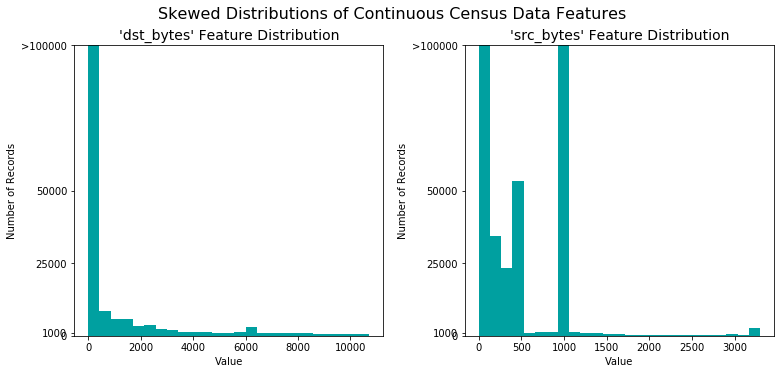

In [0]:
# Visualize skewed continuous features of original data
v.distribution(x_train)

In [0]:
# Scaling train-test data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler_data_train = scaler.fit_transform(x_train)
scaler_data_test = scaler.fit_transform(x_test)

x_train = pd.DataFrame(data = scaler_data_train, index=x_train.index, columns=x_train.columns)
x_test = pd.DataFrame(data = scaler_data_test, index=x_test.index, columns=x_test.columns)

C:\Users\Elsahy\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int8, int16 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Elsahy\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int8, int16 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


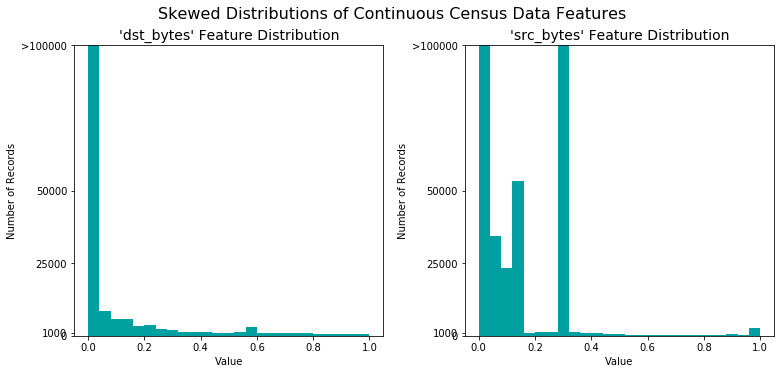

In [0]:
# Visualize scaled data
v.distribution(x_train)

In [0]:
# show data after scaling
x_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,Urgent,Hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,0.5,0.338462,0.9,0.049712,0.445076,0.0,0.0,0.0,0.0,...,0.035294,0.035294,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0.0,0.5,0.338462,0.9,0.067293,0.043361,0.0,0.0,0.0,0.0,...,0.074510,0.074510,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0.0,0.5,0.338462,0.9,0.066081,0.122715,0.0,0.0,0.0,0.0,...,0.113725,0.113725,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0.0,0.5,0.338462,0.9,0.061231,0.122715,0.0,0.0,0.0,0.0,...,0.152941,0.152941,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0.0,0.5,0.338462,0.9,0.060624,0.187057,0.0,0.0,0.0,0.0,...,0.192157,0.192157,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


In [0]:
# show data after scaling
x_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,Urgent,Hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,1.0,0.71875,0.9,0.037555,0.013694,0.0,0.0,0.0,0.0,...,1.0,0.996078,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.71875,0.9,0.037555,0.013694,0.0,0.0,0.0,0.0,...,1.0,0.996078,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.71875,0.9,0.037555,0.013694,0.0,0.0,0.0,0.0,...,1.0,0.996078,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.71875,0.9,0.037555,0.013694,0.0,0.0,0.0,0.0,...,1.0,0.996078,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.71875,0.9,0.037555,0.013694,0.0,0.0,0.0,0.0,...,1.0,0.996078,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0


In [0]:
x_train.describe()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,Urgent,Hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,0.004786,0.233566,0.360137,0.784245,0.180587,0.033368,0.000045,0.002235,0.000005,0.001365,...,0.911650,0.739865,0.753780,0.030906,0.601935,0.009999,0.176762,0.176511,0.058118,0.057412
std,0.052822,0.287803,0.208282,0.225085,0.152777,0.125457,0.006673,0.045761,0.001837,0.027848,...,0.253903,0.415845,0.410781,0.109259,0.481309,0.056928,0.380593,0.380889,0.230590,0.230140
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.215385,0.900000,0.011822,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.180392,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.215385,0.900000,0.148833,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.500000,0.646154,0.900000,0.299485,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
# print data types and reasign data to new variabls to keep original data in dataframe type if needed
print(type(scaler_data_train))
print(type(x_train))
print(type(y_train))
x_train_df=x_train
x_test_df=x_test
y_train_df=y_train
y_test_df=y_test

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [0]:
#Change scaler_data_train/test (2D array) to X_train/test (3D array) to be able to used as an input of CNN
x_train_cnn = np.reshape(scaler_data_train, (scaler_data_train.shape[0],scaler_data_train.shape[1],1))
x_test_cnn = np.reshape(scaler_data_test, (scaler_data_test.shape[0],scaler_data_test.shape[1],1))

#Change y_train/test from array to dataframe then to matrix to be used with CNN
y_train_cnn = np.array(y_train)
y_train_cnn = to_categorical(y_train)

y_test_cnn = np.array(y_test)
y_test_cnn = to_categorical(y_test)

## Reprocess data (combine and re-shufful)
In this section I will combine training and testing files and reprocess data with the previous processing steps and  then shuffel to make training data more generalized
steps.
we will make two types of data splitting one for normal classifiers which is a data frame type and another for CNN classifier which in 3d and matrix form.
- combine training and testing files and save result file
- reprocess data with the same way as in preprocessing section
- use train_test_split to huffle and split the data into training and testing subsets with data frame output type
- change output type for cnn model

In The Data set describtion it sayes that testing data includes specific attack types not in the training data which may badly affect our score result so we will try to combine training and testing data the to reshufull and split trying to make trainig data more generalaized then re train NB model and check accuraccy

In [5]:
#It is important to note that the test data is not from the same probability distribution as the training data,
#And it includes specific attack types not in the training data and this badly affect our result so we will combine training
#and testing set to reshufull and resplit the data to make training set more generalzed

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (f1_score, accuracy_score,mean_squared_error,mean_absolute_error,fbeta_score)
#Combine data from train and test data
out = train_data.append(test_data)
with open('result.csv', 'w', encoding='utf-8') as f:
    out.to_csv(f, index=False)
combine = pd.read_csv('result.csv')
#reprocess combined dataset
label = out.iloc[:]['class']
feature = out.iloc[:,:-1]
label.unique()
feature = pd.DataFrame({col: feature[col].astype('category').cat.codes for col in feature}, index=feature.index)
label_encoder = LabelEncoder()
fit = label_encoder.fit_transform(label)
label = pd.DataFrame(fit, index=label.index, columns=['class'] )
label=label.replace((2,3,4), 0)
scaler = MinMaxScaler()
scaler_data = scaler.fit_transform(feature)
feature = pd.DataFrame(data = scaler_data, index=feature.index, columns=feature.columns)

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.2, random_state=42)

# process data for CNN model which we will use later
features = np.reshape(scaler_data, (scaler_data.shape[0],scaler_data.shape[1],1))
y_test1 = np.array(label)
labels = to_categorical(y_test1)
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(features, labels, test_size=0.2, random_state=42)
# Success
print("Training and testing split was successful.")

C:\Users\Elsahy\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int8, int16 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training and testing split was successful.


# Start Bulilding Models
## Build Naive model
- build naive model that predict that all connections are intrusion and calculate it's acc and fscore.
- This model will be a minimum threshold for all coming models including benchmark.

In [0]:
#clculate accuracy & f-score for naive model saying that all connections are intrusion
n_intrusion=129512
n_normal=31498
intrusion_percent=(n_intrusion/(n_intrusion+n_normal))*100

accuracy = intrusion_percent/100
recall = 1
precision = intrusion_percent/100

#Calculate F-score using the formula above for beta = 1 and values of precision and recall.
fscore = (1+1)*((precision*recall)/((precision*1)+recall))

print(accuracy)
print(fscore)

0.8043723992298615
0.8915813604477457


## Build a BenchMark model

In [0]:
# Tune and enhance benchmark model
# Implement GradientBoostingClassifier Naive Bayes
# Apply grid search on GradientBoosting
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.svm import SVC 
# Transform y_train to 1d
y_train=np.ravel(y_train)

#Define model 
clf = GradientBoostingClassifier(random_state=42)

# Create the parameters list you wish to tune, using a dictionary if needed.
# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = parameters = {'n_estimators': [10,100,300], 'learning_rate' : [0.01,0.1,1]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=1)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer,cv=5)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

In [18]:
#Get best Classifier Parameters
best_clf = grid_fit.best_params_
best_clf

{'learning_rate': 0.1, 'n_estimators': 300}


In [33]:
# Retrain The model with best estimator parametrs
clf = GradientBoostingClassifier(random_state=42,learning_rate=0.1,n_estimators= 300)

In [34]:
# Fit model
y_train=np.ravel(y_train)
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [35]:
# predict testing data
y_pred_gb = clf.predict(X_test)

In [36]:
# clculate and print f1score and accuracy
print("Accuracy BenchMark Threshold is : ",accuracy_score(y_test, y_pred_gb))
print("Fscore BenchMark Threshold is : ",fbeta_score(y_test,y_pred_gb,beta=1))

Accuracy BenchMark Threshold is :  0.9901372585553693
Fscore BenchMark Threshold is :  0.9747174016876294


## Build Solution Models
### Choose and Build a solution model
In this section we will train several classifiers , compare between them to choose best one to be our solution model
steps are:
- build train and testing pipline to train and test subset of the data
- Define classifiers and use pipline function to train them.
- use visualize file to visualize results

### Pipeline function

In [0]:
# Build Pipeline function to train input model in given sample sizes and return its performance
from sklearn.metrics import fbeta_score, accuracy_score
import time
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time.time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time.time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time.time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time.time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=1)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=1)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Train and visualize with using pipline function

GaussianNB trained on 6440 samples.
GaussianNB trained on 64404 samples.
GaussianNB trained on 644040 samples.
KNeighborsClassifier trained on 6440 samples.
KNeighborsClassifier trained on 64404 samples.
KNeighborsClassifier trained on 644040 samples.


C:\Users\Elsahy\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC trained on 6440 samples.


C:\Users\Elsahy\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC trained on 64404 samples.


C:\Users\Elsahy\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC trained on 644040 samples.


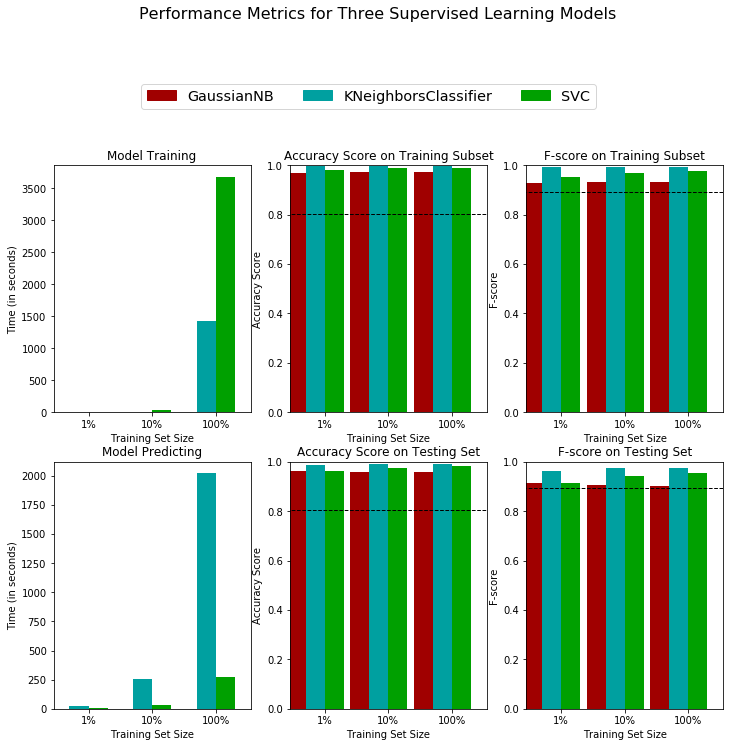

In [0]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

y_train=np.ravel(y_train)
clf_A = GaussianNB()
clf_B = KNeighborsClassifier()
clf_C = SVC(random_state=42)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = len(y_train)//10
samples_1 = len(y_train)//100

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
v.evaluate(results, accuracy, fscore)

### Choose KNN as best classifier and calculate performance

In [17]:
#Defien and Train choosen Classifier (KNN)
from sklearn.neighbors import KNeighborsClassifier
kclf = KNeighborsClassifier()
kclf.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [0]:
#predict and Calculate performance
y_pred_k = kclf.predict(X_test)
print("Accuracy Soln is : ",accuracy_score(y_test, y_pred_k))
print("Fscore Soln is : ",fbeta_score(y_test,y_pred_k,beta=1))

Accuracy BenchMark Threshold is :  0.990280106825663
Fscore BenchMark Threshold is :  0.9754390370219244


## Build CNN classifier as feature extration layer
- use CNN model and combine with KNN to improve its results

In [33]:
#Define CNN architecture
from keras import regularizers
cnn1 = Sequential()
cnn1.add(Convolution1D(57, 3, border_mode="same",activation="relu",input_shape=(41, 1)))
cnn1.add(MaxPooling1D(pool_length=(2)))
cnn1.add(Flatten())
cnn1.add(Dense(128, activation="relu"))
cnn1.add(Dropout(0.4))
cnn1.add(Dense(2, activation="softmax"))
print(cnn1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 41, 57)            228       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 20, 57)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1140)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               146048    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 258       
Total params: 146,534
Trainable params: 146,534
Non-trainable params: 0
_________________________________________________________________
None

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(57, 3, activation="relu", input_shape=(41, 1), padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  after removing the cwd from sys.path.


In [0]:
#compile
cnn1.compile(loss="categorical_crossentropy", optimizer="Adam",metrics=['accuracy'])

In [35]:
# Layers definitions
from keras import backend as K
for l in range(len(cnn1.layers)):
    print(l, cnn1.layers[l])

0 <keras.layers.convolutional.Conv1D object at 0x7f371d995048>
1 <keras.layers.pooling.MaxPooling1D object at 0x7f371d995080>
2 <keras.layers.core.Flatten object at 0x7f371d995390>
3 <keras.layers.core.Dense object at 0x7f371d995ac8>
4 <keras.layers.core.Dropout object at 0x7f371d995668>
5 <keras.layers.core.Dense object at 0x7f371d94a208>


In [0]:
# feature extraction layer
getFeature = K.function([cnn1.layers[0].input, K.learning_phase()],
                        [cnn1.layers[3].output])

In [0]:
# classification layer
getPrediction = K.function([cnn1.layers[4].input, K.learning_phase()],
                           [cnn1.layers[5].output])

In [0]:
#extract features
#excuting this cell will cause error if there is't enough GPU memory space
exTrain = getFeature([X_train_cnn[:], 0],)[0]
exTest = getFeature([X_test_cnn[:], 0])[0]

In [0]:
#reshape labels data to use with KNN
y_test_cnn2=np.argmax(y_test_cnn,axis=1)
y_train_cnn2=np.argmax(y_train_cnn,axis=1)

y_train_cnn1 = y_train_cnn2[:].reshape(y_train_cnn2[:].shape[0],)
y_test_cnn1 = y_test_cnn2[:].reshape(y_test_cnn2[:].shape[0],)

In [0]:
# define and train KNN classifier on extracted features
from sklearn.neighbors import KNeighborsClassifier
kclf = KNeighborsClassifier()
kclf.fit(exTrain, y_train_cnn1)
y_pred_knn = kclf.predict(exTest)

In [0]:
# predict testing features it will take about 1 hour
y_pred_knn = kclf.predict(exTest)

In [41]:
# Calculate accuracy and F1-score
print("Accuracy: {0}".format(accuracy_score(y_test_cnn1, y_pred_knn)))
print("F-score: {0}".format(fbeta_score(y_test_cnn1, y_pred_knn,beta=1)))

Accuracy: 0.9907272840196261
F-score: 0.9760886625346337


##### -----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Visualization Model Results
## Build Confusion Matrix

In [42]:
#clculate and print confusion matrix
from sklearn import metrics
cm = metrics.confusion_matrix(y_test_cnn1, y_pred_knn)
cm

array([[129044,    468],
       [  1025,  30473]])

Confusion matrix, without normalization
[[129044    468]
 [  1025  30473]]
Normalized confusion matrix
[[0.9964 0.0036]
 [0.0325 0.9675]]


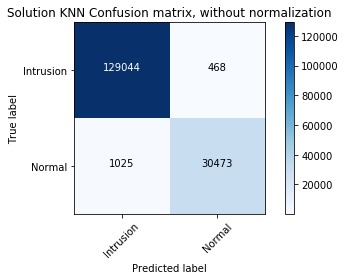

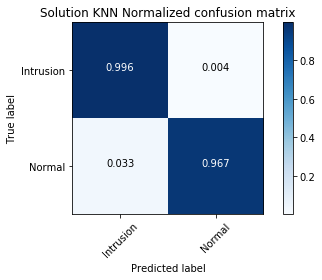

In [47]:
# visualize Confusion matrix with and without normalization
import itertools
import Visuals as v
from sklearn import metrics
# Compute confusion matrix
cnf_matrix =metrics.confusion_matrix(y_test_cnn1, y_pred_knn)
np.set_printoptions(precision=4)
# Plot non-normalized confusion matrix
plt.figure()
v.plot_confusion_matrix(cnf_matrix, classes=['Intrusion','Normal'], title='Solution KNN Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
v.plot_confusion_matrix(cnf_matrix, classes=['Intrusion','Normal'], normalize=True,title='Solution KNN Normalized confusion matrix')

plt.show()

## Build ROC AUC Curve

AUC: 0.998751


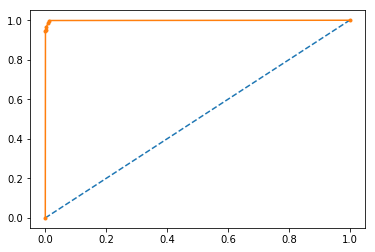

In [48]:
# roc curve and auc of Solution KNN Model
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# predict probabilities
probs = kclf.predict_proba(exTest)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test_cnn1, probs)
print('AUC: %.6f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test_cnn1, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [59]:
# Benchmark and Solution model Comparison in Accuracy and F1-score
print("********Benchmark********* ")
print("Accuracy BenchMark Threshold is : ",accuracy_score(y_test, y_pred_gb))
print("F1-score BenchMark Threshold is : ",fbeta_score(y_test,y_pred_gb,beta=1))
print("********Solution********** ")
print("Accuracy Soln is : ",(accuracy_score(y_test_cnn1, y_pred_knn)))
print("F1-score Soln is : ",fbeta_score(fbeta_score(y_test_cnn1, y_pred_knn,beta=1)))

********Benchmark********* 
Accuracy BenchMark Threshold is :  0.9901372585553693
F1-score BenchMark Threshold is :  0.9747174016876294
********Solution********** 
Accuracy Soln is :  0.9907272840196261
F1-score Soln is :  0.9760886625346337
